### Parse azure rules

Since there is no rule name in the logs, we are going to parse html extracted from the Azure portal WAF policies, since it includes a table with rules ids and rule names.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup

# Opening the rules HTML file
with open('azure-rules.html', 'r') as file:
    html_content = file.read()

# Parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Initialize lists to store data
rows_data = []

# Find all divs with class 'ms-List-cell', which represent each row
rows = soup.find_all("div", {"class": "ms-List-cell"})

# Iterate through each row
for row in rows:
    try:
        # Extract values for each column
        rule_id = row.find("div", {"data-automation-key": "RuleId"}).text.strip().replace('\n', '')
        description = row.find("div", {"data-automation-key": "Description"}).text.strip().replace('\n', '')
        action = row.find("div", {"data-automation-key": "Action"}).text.strip().replace('\n', '')
        status = row.find("div", {"data-automation-key": "Status"}).text.strip().replace('\n', '')
        exclusions = row.find("div", {"data-automation-key": "Exclusions"}).text.strip().replace('\n', '')
        rule_group = row.find("div", {"data-automation-key": "RuleGroup"}).text.strip().replace('\n', '')
        rule_set = row.find("div", {"data-automation-key": "RuleSet"}).text.strip().replace('\n', '')
        
        # Append data to the list
        rows_data.append([rule_id, description, action, status, exclusions, rule_group, rule_set])
    except AttributeError as e:
        print("Error occurred while processing a row:", e)

# Create a DataFrame
rules_df = pd.DataFrame(rows_data, columns=['RuleId', 'Description', 'Action', 'Status', 'Exclusions', 'RuleGroup', 'RuleSet'])

# Save the DataFrame to a CSV file
rules_df.to_csv('azure-rules.csv', index=False)


In [2]:
rules_df = pd.read_csv('azure-rules.csv')

In [3]:
rules_df.head()

,RuleId,Description,Action,Status,Exclusions,RuleGroup,RuleSet
0,200002,Failed to Parse Request Body.,Anomaly score,Enabled,NaN,General,OWASP_3.2
1,200003,Multipart Request Body Strict ...,Anomaly score,Enabled,NaN,General,OWASP_3.2
2,200004,Possible Multipart Unmatched ...,Anomaly score,Enabled,NaN,General,OWASP_3.2
3,911100,Method is not allowed by ...,Anomaly score,Enabled,NaN,REQUEST-911-METHOD-ENFORCEMENT,OWASP_3.2
4,913100,Found User-Agent associated ...,Anomaly score,Enabled,NaN,REQUEST-913-SCANNER-DETECTION,OWASP_3.2


In [4]:
rules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RuleId       186 non-null    int64  
 1   Description  186 non-null    object 
 2   Action       186 non-null    object 
 3   Status       186 non-null    object 
 4   Exclusions   0 non-null      float64
 5   RuleGroup    186 non-null    object 
 6   RuleSet      186 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 10.3+ KB


### WAF logs Preparation

In [5]:
# Read the CSV file
waf_logs_df = pd.read_csv('waf-gateway-logs.csv')

In [6]:
waf_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TenantId                    680 non-null    object 
 1   TimeGenerated [Local Time]  680 non-null    object 
 2   OperationName               680 non-null    object 
 3   InstanceId                  680 non-null    object 
 4   ClientIp                    680 non-null    object 
 5   ClientPort                  0 non-null      float64
 6   RequestUri                  680 non-null    object 
 7   RuleSetType                 680 non-null    object 
 8   RuleSetVersion              519 non-null    float64
 9   RuleId                      519 non-null    float64
 10  Message                     680 non-null    object 
 11  Action                      680 non-null    object 
 12  Site                        0 non-null      float64
 13  DetailedMessage             519 non

In [7]:
# rows with missing RuleId
no_rule = waf_logs_df[waf_logs_df['RuleId'].isnull()]

# count rows where 'bot' in Message
bot_count = waf_logs_df[waf_logs_df['Message'].str.contains('bot', case=False, na=False)].shape[0]

# count rows where 'bot' in RuleSetType
bot_rule_set_count = waf_logs_df[waf_logs_df['RuleSetType'].str.contains('bot', case=False, na=False)].shape[0]

print("Number of rows with missing RuleId:", no_rule.shape[0])
print("Number of rows where 'bot' is present in the Message:", bot_count)
print("Number of rows where 'bot' is present in the RuleSetType:", bot_rule_set_count)

Number of rows with missing RuleId: 161
Number of rows where 'bot' is present in the Message: 161
Number of rows where 'bot' is present in the RuleSetType: 161


In [8]:
# Fill missing values in the 'RuleId' column with '0' since it represents a bot detection rule
waf_logs_df['RuleId'] = waf_logs_df['RuleId'].fillna(0)

In [9]:
# make RuleID column as int
waf_logs_df['RuleId'] = waf_logs_df['RuleId'].astype(int)
# make TimeGenerated [Local Time] column as datetime
waf_logs_df['TimeGenerated [Local Time]'] = pd.to_datetime(waf_logs_df['TimeGenerated [Local Time]'])

C:\Users\saidm\AppData\Local\Temp\ipykernel_6176\1312437278.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  waf_logs_df['TimeGenerated [Local Time]'] = pd.to_datetime(waf_logs_df['TimeGenerated [Local Time]'])


In [10]:
waf_logs_df.head()

,TenantId,TimeGenerated [Local Time],OperationName,InstanceId,ClientIp,ClientPort,RequestUri,RuleSetType,RuleSetVersion,RuleId,...,Site,DetailedMessage,DetailedData,FileDetails,LineDetails,Hostname,TransactionId,SourceSystem,Type,_ResourceId
0,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 14:00:34,ApplicationGatewayFirewall,appgw_1,143.198.204.194,NaN,/cdn-cgi/trace,OWASP CRS,3.2,920300,...,NaN,Equal 0; Pattern match ^OPTIONS$; Pattern matc...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,speed.cloudflare.com,01b75926e10f075076df45bd4a40fa57,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...
1,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 14:07:49,ApplicationGatewayFirewall,appgw_3,205.210.31.89,NaN,/,OWASP CRS,3.2,920300,...,NaN,Equal 0; Pattern match ^OPTIONS$; Pattern matc...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,9a4c775696f93dbc0b8c2adf385a5298,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...
2,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 14:07:49,ApplicationGatewayFirewall,appgw_3,205.210.31.89,NaN,/login.php,OWASP CRS,3.2,920300,...,NaN,Equal 0; Pattern match ^OPTIONS$; Pattern matc...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,bf143d2ae7c1af54995f23977b853347,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...
3,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 13:40:57,ApplicationGatewayFirewall,appgw_3,179.43.188.106,NaN,/,OWASP CRS,3.2,920300,...,NaN,Equal 0; Pattern match ^OPTIONS$; Pattern matc...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,4236db65efe575a9d018448107e522cb,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...
4,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 13:40:57,ApplicationGatewayFirewall,appgw_3,179.43.188.106,NaN,/login.php,OWASP CRS,3.2,920300,...,NaN,Equal 0; Pattern match ^OPTIONS$; Pattern matc...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,2be542755e599a08b0249e6a5ea6685b,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...


In [11]:
# add columns Description and Status to the waf_logs_df DataFrame by joining matching RuleId values
waf_logs_df = waf_logs_df.merge(rules_df[['RuleId', 'Description', 'Status']], left_on='RuleId', right_on='RuleId', how='left')

In [12]:
waf_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TenantId                    680 non-null    object        
 1   TimeGenerated [Local Time]  680 non-null    datetime64[ns]
 2   OperationName               680 non-null    object        
 3   InstanceId                  680 non-null    object        
 4   ClientIp                    680 non-null    object        
 5   ClientPort                  0 non-null      float64       
 6   RequestUri                  680 non-null    object        
 7   RuleSetType                 680 non-null    object        
 8   RuleSetVersion              519 non-null    float64       
 9   RuleId                      680 non-null    int32         
 10  Message                     680 non-null    object        
 11  Action                      680 non-null    object        

In [13]:
# Set description to 'Microsoft Bot Detection' where RuleId is 0
waf_logs_df.loc[waf_logs_df['RuleId'] == 0, 'Description'] = 'Microsoft Bot Detection'

In [14]:
waf_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TenantId                    680 non-null    object        
 1   TimeGenerated [Local Time]  680 non-null    datetime64[ns]
 2   OperationName               680 non-null    object        
 3   InstanceId                  680 non-null    object        
 4   ClientIp                    680 non-null    object        
 5   ClientPort                  0 non-null      float64       
 6   RequestUri                  680 non-null    object        
 7   RuleSetType                 680 non-null    object        
 8   RuleSetVersion              519 non-null    float64       
 9   RuleId                      680 non-null    int32         
 10  Message                     680 non-null    object        
 11  Action                      680 non-null    object        

In [15]:
# rows with missing Description
waf_logs_df[waf_logs_df['Description'].isnull()][['RuleId', 'Description', 'Message', 'Action']]

,RuleId,Description,Message,Action
14,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 5),Blocked
23,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 8),Blocked
38,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 25),Blocked
40,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 10),Blocked
49,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 5),Blocked
...,...,...,...,...
657,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 5),Blocked
662,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 30),Blocked
668,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 15),Blocked
672,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 10),Blocked


In [16]:
waf_logs_df[waf_logs_df['Description'].isnull()]['RuleId'].value_counts()

RuleId
949110    120
Name: count, dtype: int64

In [17]:
waf_logs_df[waf_logs_df['Description'].isnull()]['Action'].value_counts()

Action
Blocked     78
Detected    42
Name: count, dtype: int64

In [18]:
waf_logs_df[waf_logs_df['Description'].isnull()]['Message'].str.contains('Score', case=False, na=False).shape[0]

120

In [19]:
# Set description to 'Anomaly Score' where RuleId is 949110 since all the Messages contains Anomaly Score info
waf_logs_df.loc[waf_logs_df['RuleId'] == 949110, 'Description'] = 'Anomaly Score'

In [20]:
waf_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TenantId                    680 non-null    object        
 1   TimeGenerated [Local Time]  680 non-null    datetime64[ns]
 2   OperationName               680 non-null    object        
 3   InstanceId                  680 non-null    object        
 4   ClientIp                    680 non-null    object        
 5   ClientPort                  0 non-null      float64       
 6   RequestUri                  680 non-null    object        
 7   RuleSetType                 680 non-null    object        
 8   RuleSetVersion              519 non-null    float64       
 9   RuleId                      680 non-null    int32         
 10  Message                     680 non-null    object        
 11  Action                      680 non-null    object        

In [21]:
waf_logs_df.head()

,TenantId,TimeGenerated [Local Time],OperationName,InstanceId,ClientIp,ClientPort,RequestUri,RuleSetType,RuleSetVersion,RuleId,...,DetailedData,FileDetails,LineDetails,Hostname,TransactionId,SourceSystem,Type,_ResourceId,Description,Status
0,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 14:00:34,ApplicationGatewayFirewall,appgw_1,143.198.204.194,NaN,/cdn-cgi/trace,OWASP CRS,3.2,920300,...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,speed.cloudflare.com,01b75926e10f075076df45bd4a40fa57,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Request Missing an Accept ...,Enabled
1,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 14:07:49,ApplicationGatewayFirewall,appgw_3,205.210.31.89,NaN,/,OWASP CRS,3.2,920300,...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,9a4c775696f93dbc0b8c2adf385a5298,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Request Missing an Accept ...,Enabled
2,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 14:07:49,ApplicationGatewayFirewall,appgw_3,205.210.31.89,NaN,/login.php,OWASP CRS,3.2,920300,...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,bf143d2ae7c1af54995f23977b853347,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Request Missing an Accept ...,Enabled
3,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 13:40:57,ApplicationGatewayFirewall,appgw_3,179.43.188.106,NaN,/,OWASP CRS,3.2,920300,...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,4236db65efe575a9d018448107e522cb,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Request Missing an Accept ...,Enabled
4,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-03 13:40:57,ApplicationGatewayFirewall,appgw_3,179.43.188.106,NaN,/login.php,OWASP CRS,3.2,920300,...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,2be542755e599a08b0249e6a5ea6685b,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Request Missing an Accept ...,Enabled


In [22]:
# Replace the "                                " with " " in the Description column
waf_logs_df['Description'] = waf_logs_df['Description'].str.replace("                                ", " ")



In [23]:
# Save the updated DataFrame to a CSV file
waf_logs_df.to_csv('waf-gateway-logs-cleaned.csv', index=False)

In [24]:
# Read the CSV file
#waf_logs_df = pd.read_csv('waf-gateway-logs-cleaned.csv')

### WAF logs analysis

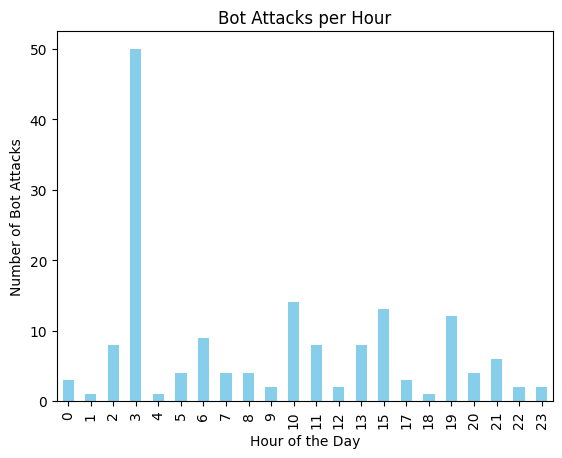

In [25]:
# plot bot attacks per hour (grouping the TimeGenerated [Local Time] column by hour and counting the number of bot attacks)
import matplotlib.pyplot as plt

waf_logs_df[waf_logs_df['Description'].str.contains('bot', case=False, na=False)].groupby(waf_logs_df['TimeGenerated [Local Time]'].dt.hour)['Description'].count().plot(kind='bar', color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Bot Attacks')
plt.title('Bot Attacks per Hour')
plt.show()

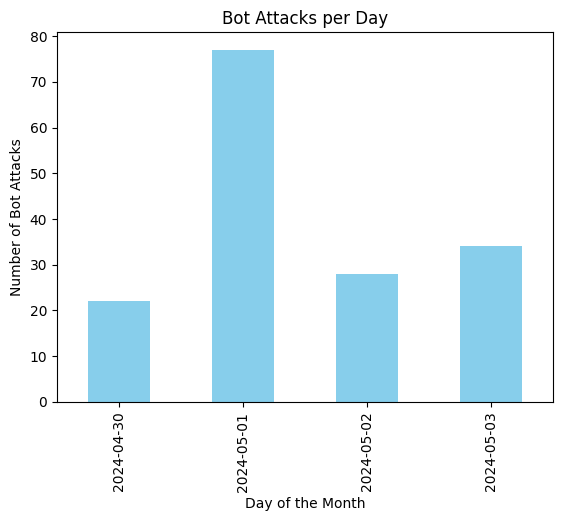

In [26]:
# same plot but per day
waf_logs_df[waf_logs_df['Description'].str.contains('bot', case=False, na=False)].groupby(waf_logs_df['TimeGenerated [Local Time]'].dt.date)['Description'].count().plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Bot Attacks')
plt.title('Bot Attacks per Day')
plt.show()

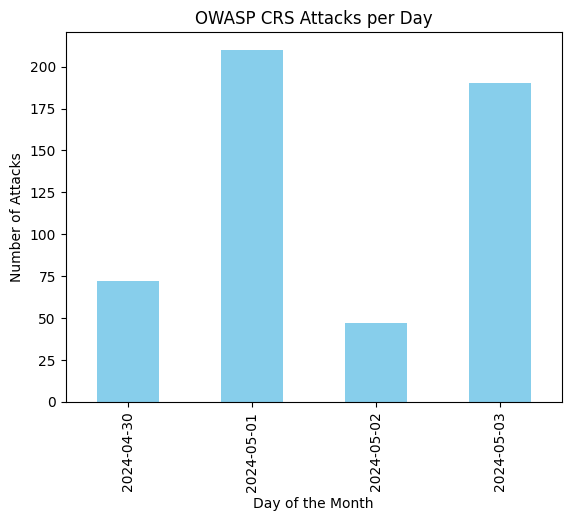

In [27]:

waf_logs_df[waf_logs_df['RuleSetType']=='OWASP CRS'].groupby(waf_logs_df['TimeGenerated [Local Time]'].dt.date)['Description'].count().plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Attacks')
plt.title('OWASP CRS Attacks per Day')
plt.show()

Text(0.5, 1.0, 'Top 5 OWASP CRS Attacks per Day')

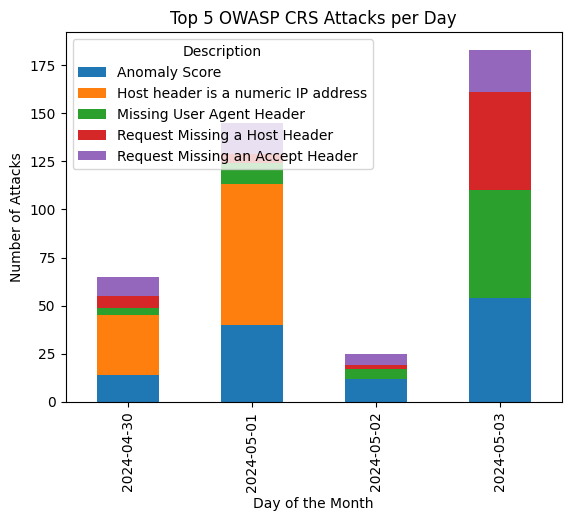

In [28]:
waf_OWASP_CRS = waf_logs_df[waf_logs_df['RuleSetType']=='OWASP CRS']
waf_OWASP_CRS['Description'].value_counts()
# extract the top 5 attacks from OWASP CRS
top_5_OWASP_CRS_attacks = waf_OWASP_CRS['Description'].value_counts().head(5)
# filter the waf_OWASP_CRS DataFrame to include only the top 5 attacks
waf_OWASP_CRS = waf_OWASP_CRS[waf_OWASP_CRS['Description'].isin(top_5_OWASP_CRS_attacks.index)]
#plot the  attacks per day
waf_OWASP_CRS.groupby([waf_OWASP_CRS['TimeGenerated [Local Time]'].dt.date, waf_OWASP_CRS['Description']])['Description'].count().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Day of the Month')
plt.ylabel('Number of Attacks')
plt.title('Top 5 OWASP CRS Attacks per Day')


Text(0.5, 1.0, 'Top 5 OWASP CRS Attacks per Hour')

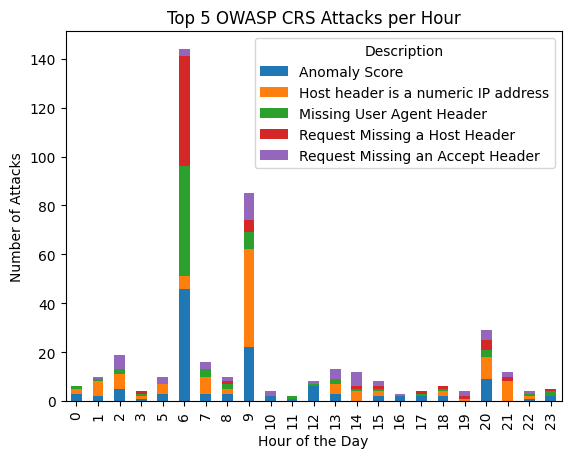

In [29]:
#plot the  attacks per hour
waf_OWASP_CRS.groupby([waf_OWASP_CRS['TimeGenerated [Local Time]'].dt.hour, waf_OWASP_CRS['Description']])['Description'].count().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Attacks')
plt.title('Top 5 OWASP CRS Attacks per Hour')
